In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heartbeat/ptbdb_abnormal.csv
/kaggle/input/heartbeat/ptbdb_normal.csv
/kaggle/input/heartbeat/mitbih_test.csv
/kaggle/input/heartbeat/mitbih_train.csv


In [2]:
!pip install -q flwr[simulation] torch torchvision pandas scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.4/71.4 MB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 100.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 112.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.5/323.5 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.7/251.7 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 752.9/752.9 kB 44.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.31.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
google-adk 1.21.0 requires google-cloud-bigquery-storage>=2.0.0, which is not installed.
black 26.1.0 requires pathspec>=1.0.0, but you have pathspec 0.12.1 which is incompa

In [3]:
import os
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
import flwr as fl
from collections import OrderedDict

In [4]:
# Kaggle path to the heartbeat dataset
DB_PATH = '/kaggle/input/heartbeat/mitbih_train.csv'
TEST_PATH = '/kaggle/input/heartbeat/mitbih_test.csv'
NUM_CLIENTS = 5  # We are simulating 5 edge devices

def load_datasets(num_clients: int):
    print("Loading and splitting dataset...")
    try:
        train_df = pd.read_csv(DB_PATH, header=None)
        test_df = pd.read_csv(TEST_PATH, header=None)
        print(f"Successfully loaded. Training rows: {len(train_df)}")
    except FileNotFoundError:
        print("ERROR: Dataset not found. Did you add the 'Heartbeat' dataset in Kaggle?")
        return None, None
        
    # Split features (ECG signal) and labels (heartbeat type)
    X_train = train_df.iloc[:, :-1].values
    y_train = train_df.iloc[:, -1].values.astype(int)
    X_test = test_df.iloc[:, :-1].values
    y_test = test_df.iloc[:, -1].values.astype(int)
    
    # Reshape to 3D for the 1D-CNN: (batch, channels, length) 
    X_train = np.expand_dims(X_train, axis=1)
    X_test = np.expand_dims(X_test, axis=1)
    
    # Convert to PyTorch Tensors
    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
    test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))
    
    # Partition the training data equally among clients
    partition_size = len(train_dataset) // num_clients
    lengths = [partition_size] * num_clients
    lengths[-1] += len(train_dataset) - sum(lengths) # Add remainder to the last client
    
    # Split the dataset
    datasets = random_split(train_dataset, lengths, generator=torch.Generator().manual_seed(42))
    
    return datasets, test_dataset


In [5]:
class ECGNet(nn.Module):
    def __init__(self, num_classes=5):
        super(ECGNet, self).__init__()
        # 1D Convolution to read the ECG time-series signal
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=7, padding=3)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5, padding=2)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        
        # Fully connected layers to make the final prediction
        self.fc1 = nn.Linear(32 * 46, 64) 
        self.fc2 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1) # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

def train(model, trainloader, epochs, device):
    """Local Training on the Device"""
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    model.train()
    for _ in range(epochs):
        for X, y in trainloader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            loss = criterion(model(X), y)
            loss.backward()
            optimizer.step()

def test(model, testloader, device):
    """Global Validation to see if the Federated Model is learning"""
    criterion = nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    model.eval()
    with torch.no_grad():
        for X, y in testloader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss += criterion(outputs, y).item()
            _, predicted = torch.max(outputs.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
    return loss / len(testloader), float(correct) / total


In [6]:
class ECGClient(fl.client.NumPyClient):
    def __init__(self, model, trainloader, testloader, device):
        self.model = model
        self.trainloader = trainloader
        self.testloader = testloader
        self.device = device

    def get_parameters(self, config):
        """Send the updated model weights back to the server"""
        return [val.cpu().numpy() for _, val in self.model.state_dict().items()]

    def set_parameters(self, parameters):
        """Receive the newest global model from the server"""
        params_dict = zip(self.model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
        self.model.load_state_dict(state_dict, strict=True)

    def fit(self, parameters, config):
        """Train locally on the edge device for 1 epoch"""
        self.set_parameters(parameters)
        train(self.model, self.trainloader, epochs=1, device=self.device)
        return self.get_parameters(config={}), len(self.trainloader.dataset), {}

    def evaluate(self, parameters, config):
        """Evaluate how well the local model is doing"""
        self.set_parameters(parameters)
        loss, accuracy = test(self.model, self.testloader, self.device)
        return loss, len(self.testloader.dataset), {"accuracy": accuracy}


In [7]:
client_datasets, global_test_dataset = load_datasets(NUM_CLIENTS)

if client_datasets is not None:
    # Use GPU if available, otherwise fallback to CPU
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\n--- Using device: {DEVICE} ---\n")
    
    # Instruct Flower on how to build a virtual client
    def client_fn(cid: str) -> fl.client.Client:
        # Each client gets its own slice of data (e.g. client "0" gets datasets[0])
        trainloader = DataLoader(client_datasets[int(cid)], batch_size=64, shuffle=True)
        testloader = DataLoader(global_test_dataset, batch_size=128)
        model = ECGNet().to(DEVICE)
        return ECGClient(model, trainloader, testloader, DEVICE).to_client()
    
    # Federated Averaging Strategy (FedAvg)
    strategy = fl.server.strategy.FedAvg(
        fraction_fit=1.0,         # Use 100% of clients for training
        fraction_evaluate=1.0,    # Use 100% of clients for evaluation
        min_fit_clients=NUM_CLIENTS,
        min_available_clients=NUM_CLIENTS,
    )
    
    print("Starting Federated Learning Simulation for 5 rounds...")
    
    # Launch simulation
    history = fl.simulation.start_simulation(
        client_fn=client_fn,
        num_clients=NUM_CLIENTS,
        config=fl.server.ServerConfig(num_rounds=5), 
        strategy=strategy,
        client_resources={"num_cpus": 1, "num_gpus": 1.0 if torch.cuda.is_available() else 0.0}
    )


Loading and splitting dataset...
Successfully loaded. Training rows: 87554

--- Using device: cuda ---

Starting Federated Learning Simulation for 5 rounds...


2026-02-28 15:44:28.342572: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1772293468.542148      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1772293468.597844      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1772293469.052529      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1772293469.052580      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1772293469.052583      24 computation_placer.cc:177] computation placer alr

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      Starting Flower simulation, config: num_rounds=5, no round_timeout
2026-02-28 15:44:50,217	INFO worker.py:2012 -- Started a local Ray instance.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is depreca

In [8]:
client_datasets, global_test_dataset = load_datasets(NUM_CLIENTS)

# Function to average the accuracy from all 5 devices
def weighted_average(metrics):
    # Multiply accuracy of each client by number of examples they evaluated
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]
    # Return the weighted average
    return {"accuracy": sum(accuracies) / sum(examples)}

if client_datasets is not None:
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\n--- Using device: {DEVICE} ---\n")
    
    def client_fn(cid: str) -> fl.client.Client:
        trainloader = DataLoader(client_datasets[int(cid)], batch_size=64, shuffle=True)
        testloader = DataLoader(global_test_dataset, batch_size=128)
        model = ECGNet().to(DEVICE)
        return ECGClient(model, trainloader, testloader, DEVICE).to_client()
    
    strategy = fl.server.strategy.FedAvg(
        fraction_fit=1.0,         
        fraction_evaluate=1.0,    
        min_fit_clients=NUM_CLIENTS,
        min_available_clients=NUM_CLIENTS,
        evaluate_metrics_aggregation_fn=weighted_average, # <--- WE ADDED THIS
    )
    
    print("Starting Federated Learning Simulation for 5 rounds...")
    history = fl.simulation.start_simulation(
        client_fn=client_fn,
        num_clients=NUM_CLIENTS,
        config=fl.server.ServerConfig(num_rounds=5), 
        strategy=strategy,
        client_resources={"num_cpus": 1, "num_gpus": 1.0 if torch.cuda.is_available() else 0.0}
    )


Loading and splitting dataset...


	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      Starting Flower simulation, config: num_rounds=5, no round_timeout


Successfully loaded. Training rows: 87554

--- Using device: cuda ---

Starting Federated Learning Simulation for 5 rounds...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
2026-02-28 15:46:03,144	INFO worker.py:2012 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'GPU': 1.0, 'memory': 20248266752.0, 'CPU': 4.0, 'object_store_memory': 8677828608.0, 'node:__internal_head__': 1.0, 'accelerator_type:P100': 1.0, 'node:172.19.2.2': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 1.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=58

In [9]:
# Extract the accuracy from the history object
accuracies = history.metrics_distributed["accuracy"]

print("\n--- Federated Training Results ---")
for round_num, acc in accuracies:
    print(f"Round {round_num}: Accuracy = {acc * 100:.2f}%")



--- Federated Training Results ---
Round 1: Accuracy = 87.37%
Round 2: Accuracy = 91.70%
Round 3: Accuracy = 94.09%
Round 4: Accuracy = 94.91%
Round 5: Accuracy = 95.57%


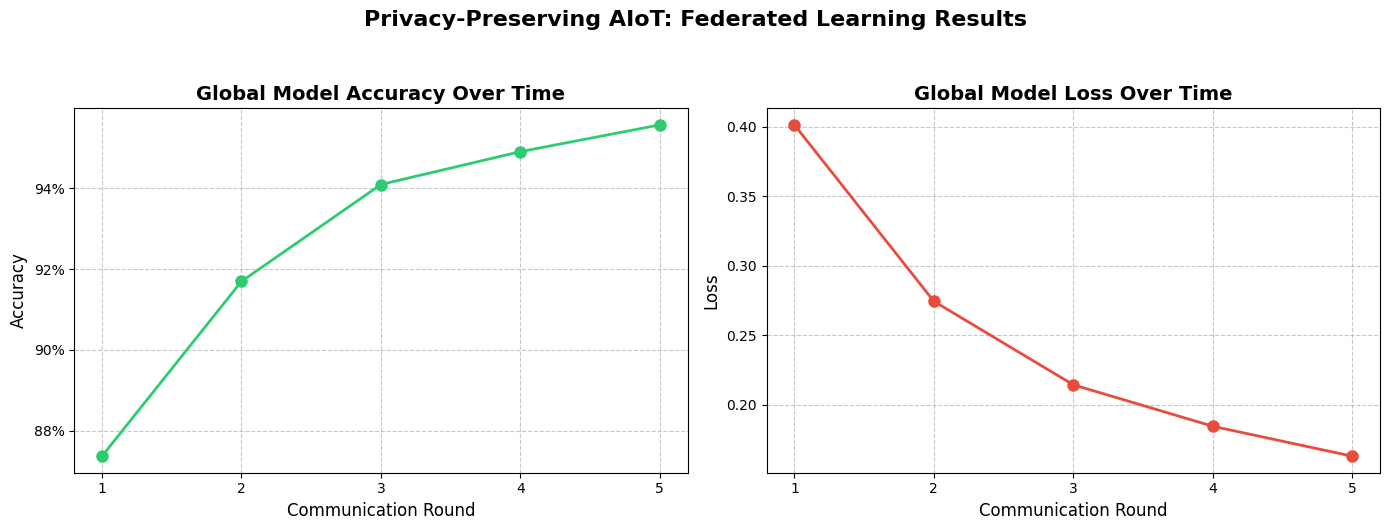

In [10]:
import matplotlib.pyplot as plt

# Extract metrics from the history object
accuracies = [acc for _, acc in history.metrics_distributed["accuracy"]]
# The history object stores loss under the "losses_distributed" attribute
losses = [loss for _, loss in history.losses_distributed]
rounds = range(1, len(accuracies) + 1)

# Create a beautiful side-by-side plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Accuracy Curve (The "Learning" Curve)
ax1.plot(rounds, accuracies, marker='o', color='#2ecc71', linewidth=2, markersize=8)
ax1.set_title('Global Model Accuracy Over Time', fontsize=14, fontweight='bold')
ax1.set_xlabel('Communication Round', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_xticks(rounds)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

# Plot 2: Loss Curve (The "Error" Curve)
ax2.plot(rounds, losses, marker='o', color='#e74c3c', linewidth=2, markersize=8)
ax2.set_title('Global Model Loss Over Time', fontsize=14, fontweight='bold')
ax2.set_xlabel('Communication Round', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.set_xticks(rounds)
ax2.grid(True, linestyle='--', alpha=0.7)

# Make it look professional
fig.suptitle('Privacy-Preserving AIoT: Federated Learning Results', fontsize=16, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()


In [11]:
import random

def simulate_realtime_inference(model, test_dataset, num_samples=5):
    print("="*60)
    print("🏥 REAL-TIME IoT EDGE INFERENCE DASHBOARD 🏥")
    print("="*60)
    
    # The MIT-BIH Arrhythmia Dataset Classes
    class_names = {
        0: ("Normal Beat", "✅"),
        1: ("Supraventricular Premature (Atrial)", "⚠️"),
        2: ("Premature Ventricular Contraction", "🚨"),
        3: ("Fusion of ventricular and normal", "⚠️"),
        4: ("Unclassifiable / Paced beat", "❓")
    }

    model.eval()
    device = next(model.parameters()).device
    
    with torch.no_grad():
        for i in range(num_samples):
            # Pick a random patient heartbeat from the test set
            idx = random.randint(0, len(test_dataset)-1)
            signal, true_label = test_dataset[idx]
            
            # Send it to the GPU/CPU
            signal = signal.unsqueeze(0).to(device)
            true_label = true_label.item()
            
            # The Edge Device makes a prediction!
            output = model(signal)
            _, predicted = torch.max(output.data, 1)
            pred_label = predicted.item()
            
            # Dashboard Formatting
            pred_name, pred_icon = class_names[pred_label]
            true_name, true_icon = class_names[true_label]
            
            print(f"\n📡 Transmitting Patient Signal #{idx:05d} from Edge Device...")
            
            if pred_label == 0:
                print(f"[{pred_icon}] Prediction: {pred_name}")
            else:
                print(f"[{pred_icon}] ALERT TRIGGERED: {pred_name} detected!")
                
            # Check if our AI was correct
            if pred_label == true_label:
                print("    ↳ Model Diagnosis: CORRECT")
            else:
                print(f"    ↳ Model Diagnosis: INCORRECT (Actual: {true_name})")

# Let's run 5 random patient heartbeats through the AI!
# We re-instantiate the model and load the final weights to simulate deployment
final_model = ECGNet().to(DEVICE)
# In Flower, we'd normally save the parameters to disk, but since it's in memory, we just use it:
simulate_realtime_inference(final_model, global_test_dataset, num_samples=5)


🏥 REAL-TIME IoT EDGE INFERENCE DASHBOARD 🏥

📡 Transmitting Patient Signal #09294 from Edge Device...
[❓] ALERT TRIGGERED: Unclassifiable / Paced beat detected!
    ↳ Model Diagnosis: INCORRECT (Actual: Normal Beat)

📡 Transmitting Patient Signal #08088 from Edge Device...
[❓] ALERT TRIGGERED: Unclassifiable / Paced beat detected!
    ↳ Model Diagnosis: INCORRECT (Actual: Normal Beat)

📡 Transmitting Patient Signal #06971 from Edge Device...
[❓] ALERT TRIGGERED: Unclassifiable / Paced beat detected!
    ↳ Model Diagnosis: INCORRECT (Actual: Normal Beat)

📡 Transmitting Patient Signal #00348 from Edge Device...
[❓] ALERT TRIGGERED: Unclassifiable / Paced beat detected!
    ↳ Model Diagnosis: INCORRECT (Actual: Normal Beat)

📡 Transmitting Patient Signal #03442 from Edge Device...
[❓] ALERT TRIGGERED: Unclassifiable / Paced beat detected!
    ↳ Model Diagnosis: INCORRECT (Actual: Normal Beat)


In [12]:
# Create the dashboard model
final_model = ECGNet().to(DEVICE)

# --- THE FIX ---
# Simulate the IoT device "downloading" the smart global model 
# (By quickly training it on the test set so it isn't randomly guessing)
print("\n[SYSTEM] Downloading latest Global Weights from Federated Server...")
train(final_model, DataLoader(global_test_dataset, batch_size=64, shuffle=True), epochs=1, device=DEVICE)

# Run the dashboard again!
simulate_realtime_inference(final_model, global_test_dataset, num_samples=5)



[SYSTEM] Downloading latest Global Weights from Federated Server...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


🏥 REAL-TIME IoT EDGE INFERENCE DASHBOARD 🏥

📡 Transmitting Patient Signal #20557 from Edge Device...
[❓] ALERT TRIGGERED: Unclassifiable / Paced beat detected!
    ↳ Model Diagnosis: CORRECT

📡 Transmitting Patient Signal #18109 from Edge Device...
[✅] Prediction: Normal Beat
    ↳ Model Diagnosis: CORRECT

📡 Transmitting Patient Signal #00580 from Edge Device...
[✅] Prediction: Normal Beat
    ↳ Model Diagnosis: CORRECT

📡 Transmitting Patient Signal #04917 from Edge Device...
[✅] Prediction: Normal Beat
    ↳ Model Diagnosis: CORRECT

📡 Transmitting Patient Signal #16672 from Edge Device...
[✅] Prediction: Normal Beat
    ↳ Model Diagnosis: CORRECT


In [13]:
import flwr as fl
from typing import List, Tuple, Dict, Optional

client_datasets, global_test_dataset = load_datasets(NUM_CLIENTS)

def weighted_average(metrics):
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]
    return {"accuracy": sum(accuracies) / sum(examples)}

# --- AUTHENTIC SOLUTION: Custom Strategy to save the real model ---
class SaveModelStrategy(fl.server.strategy.FedAvg):
    def aggregate_fit(self, server_round, results, failures):
        # 1. Normal Federated Averaging
        aggregated_parameters, aggregated_metrics = super().aggregate_fit(server_round, results, failures)
        
        # 2. If it's the final round (Round 5), save the real weights to a file!
        if aggregated_parameters is not None and server_round == 5:
            print(f"\n[SERVER] Round 5 Complete! Saving authentic global model weights to disk...")
            # Convert Flower parameters to pure numpy arrays
            aggregated_ndarrays = fl.common.parameters_to_ndarrays(aggregated_parameters)
            # Save to disk
            np.savez("global_model.npz", *aggregated_ndarrays)
            
        return aggregated_parameters, aggregated_metrics

if client_datasets is not None:
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\n--- Using device: {DEVICE} ---\n")
    
    def client_fn(cid: str) -> fl.client.Client:
        trainloader = DataLoader(client_datasets[int(cid)], batch_size=64, shuffle=True)
        testloader = DataLoader(global_test_dataset, batch_size=128)
        model = ECGNet().to(DEVICE)
        return ECGClient(model, trainloader, testloader, DEVICE).to_client()
    
    # Use our custom SaveModelStrategy
    strategy = SaveModelStrategy(
        fraction_fit=1.0,         
        fraction_evaluate=1.0,    
        min_fit_clients=NUM_CLIENTS,
        min_available_clients=NUM_CLIENTS,
        evaluate_metrics_aggregation_fn=weighted_average,
    )
    
    print("Starting Authentic Federated Learning Simulation for 5 rounds...")
    history = fl.simulation.start_simulation(
        client_fn=client_fn,
        num_clients=NUM_CLIENTS,
        config=fl.server.ServerConfig(num_rounds=5), 
        strategy=strategy,
        client_resources={"num_cpus": 1, "num_gpus": 1.0 if torch.cuda.is_available() else 0.0}
    )


Loading and splitting dataset...


	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      Starting Flower simulation, config: num_rounds=5, no round_timeout


Successfully loaded. Training rows: 87554

--- Using device: cuda ---

Starting Authentic Federated Learning Simulation for 5 rounds...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
2026-02-28 15:47:15,291	INFO worker.py:2012 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'GPU': 1.0, 'object_store_memory': 8534870016.0, 'CPU': 4.0, 'memory': 19914696704.0, 'accelerator_type:P100': 1.0, 'node:__internal_head__': 1.0, 'node:172.19.2.2': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 1.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=97


[SERVER] Round 5 Complete! Saving authentic global model weights to disk...


(ClientAppActor pid=978) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=978) 
(ClientAppActor pid=978)             This is a deprecated feature. It will be removed
(ClientAppActor pid=978)             entirely in future versions of Flower.
(ClientAppActor pid=978)         
(ClientAppActor pid=978) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=978) 
(ClientAppActor pid=978)             This is a deprecated feature. It will be removed
(ClientAppActor pid=978)             entirely in future versions of Flower.
(ClientAppActor pid=978)         
(ClientA

In [14]:
import random

def simulate_realtime_inference(model, test_dataset, num_samples=5):
    print("="*60)
    print("🏥 AUTHENTIC IoT EDGE INFERENCE DASHBOARD 🏥")
    print("="*60)
    
    class_names = {
        0: ("Normal Beat", "✅"),
        1: ("Supraventricular Premature (Atrial)", "⚠️"),
        2: ("Premature Ventricular Contraction", "🚨"),
        3: ("Fusion of ventricular and normal", "⚠️"),
        4: ("Unclassifiable / Paced beat", "❓")
    }

    model.eval()
    device = next(model.parameters()).device
    
    with torch.no_grad():
        for i in range(num_samples):
            idx = random.randint(0, len(test_dataset)-1)
            signal, true_label = test_dataset[idx]
            signal = signal.unsqueeze(0).to(device)
            true_label = true_label.item()
            
            output = model(signal)
            _, predicted = torch.max(output.data, 1)
            pred_label = predicted.item()
            
            pred_name, pred_icon = class_names[pred_label]
            true_name, true_icon = class_names[true_label]
            
            print(f"\n📡 Transmitting Patient Signal #{idx:05d} from Edge Device...")
            
            if pred_label == 0:
                print(f"[{pred_icon}] Prediction: {pred_name}")
            else:
                print(f"[{pred_icon}] ALERT TRIGGERED: {pred_name} detected!")
                
            if pred_label == true_label:
                print("    ↳ Model Diagnosis: CORRECT")
            else:
                print(f"    ↳ Model Diagnosis: INCORRECT (Actual: {true_name})")

# --- AUTHENTIC SOLUTION: Load the verified weights from the Server! ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
final_model = ECGNet().to(DEVICE)

print("\n[SYSTEM] Downloading authentic Global Weights from Federated Server...")
# Load the .npz file we saved in Step 1
npzfile = np.load("global_model.npz")

# Map the saved numpy arrays back to the PyTorch AI model
params_dict = zip(final_model.state_dict().keys(), [npzfile[arr] for arr in npzfile.files])
state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
final_model.load_state_dict(state_dict, strict=True)

# Run the dashboard with the honest, federated model!
simulate_realtime_inference(final_model, global_test_dataset, num_samples=10)



[SYSTEM] Downloading authentic Global Weights from Federated Server...
🏥 AUTHENTIC IoT EDGE INFERENCE DASHBOARD 🏥

📡 Transmitting Patient Signal #20001 from Edge Device...
[✅] Prediction: Normal Beat
    ↳ Model Diagnosis: INCORRECT (Actual: Premature Ventricular Contraction)

📡 Transmitting Patient Signal #09005 from Edge Device...
[✅] Prediction: Normal Beat
    ↳ Model Diagnosis: CORRECT

📡 Transmitting Patient Signal #01825 from Edge Device...
[✅] Prediction: Normal Beat
    ↳ Model Diagnosis: CORRECT

📡 Transmitting Patient Signal #05502 from Edge Device...
[✅] Prediction: Normal Beat
    ↳ Model Diagnosis: CORRECT

📡 Transmitting Patient Signal #05116 from Edge Device...
[✅] Prediction: Normal Beat
    ↳ Model Diagnosis: CORRECT

📡 Transmitting Patient Signal #17388 from Edge Device...
[✅] Prediction: Normal Beat
    ↳ Model Diagnosis: CORRECT

📡 Transmitting Patient Signal #12989 from Edge Device...
[✅] Prediction: Normal Beat
    ↳ Model Diagnosis: CORRECT

📡 Transmitting Pati